<a href="https://colab.research.google.com/github/Devansh4724/Pulpnet/blob/main/Week1-2/240340_DevanshChaturvedi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing the necessary Libraries and Packages

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
import spacy
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# 1) Reading the CSV file

In [ ]:
df = pd.read_csv("/content/movie.csv")

# Exploratory Data Analysis

i) Basic Structure of the data

In [ ]:
df.head()

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


ii) Checking for and dropping the duplicate entries

In [ ]:
for i in df['text'].duplicated():
  if (i==True):
    print("Duplicate value exists")
    break

df=df.drop_duplicates()
print(f'After dropping duplicates, new data shape: {df.shape}')

Duplicate value exists
After dropping duplicates, new data shape: (39723, 2)


iii) Dropping missing entries

In [ ]:
df=df.dropna(axis=0)
print(f'After dropping missing entries, new data shape: {df.shape}')

After dropping missing entries, new data shape: (39723, 2)


iv) Checking inconsistency in data

In [ ]:
for i in df['label']:
  if (i!=0 and i!=1):
    print(i)

v) Distribution between positive and negative reviews

In [ ]:
df['label'].value_counts()

,count
label,
1,19908
0,19815


vi) Graph of length of reviews vs the sentiment

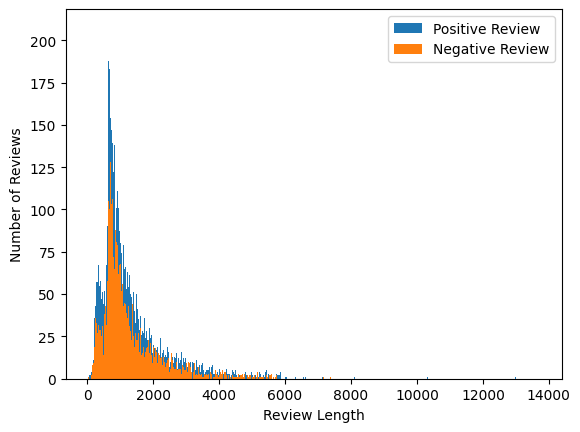

In [ ]:
lengths=[]
lengthsp=[]
lengthsn=[]
label=[]
for i in df['text']:
  lengths.append(len(i))
for i in df['label']:
  label.append(i)
j=0
for j in range(len(label)):
  if(label[j]==0):
    lengthsn.append(lengths[j])
  else:
    lengthsp.append(lengths[j])

plt.hist(lengthsp,bins=2000)
plt.hist(lengthsn,bins=2000)
plt.legend(["Positive Review","Negative Review"])
plt.xlabel("Review Length")
plt.ylabel("Number of Reviews")
plt.show()

# 2) Data Pre-Processing

Removing non-alphabetic characters and non-numerals, conversion to lowercase and applying Tokenization

In [ ]:
index1=0
tokenizer = RegexpTokenizer(r'\w+')
for review in df['text']:
  review = review.lower()
  review = re.sub(r'[^\w\s]', '', review)
  review = re.sub(r'\d+', '', review)
  df['text'].iloc[index1]=review
  index1+=1
tokenizer = RegexpTokenizer(r'\w+')
df['text'] = df['text'].apply(tokenizer.tokenize)

Streaming output truncated to the last 5000 lines.
See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['text'].iloc[index1]=review
<ipython-input-9-c0dec2f7ab1a>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'].iloc[index1]=review
<ipython-input-9-c0dec2f7ab1a>:7: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting 

Applying Stemming

In [ ]:
stemmer = PorterStemmer()
df['text'] = df['text'].apply(lambda words: [stemmer.stem(word) for word in words])
df['text'] = df['text'].apply(lambda words: ' '.join(words))

Applying Lemmatisation

In [ ]:
nlp = spacy.load("en_core_web_sm",disable=["ner", "parser"])
reviews = df['text'].to_list()
lemmatized_reviews = []
for review in tqdm(nlp.pipe(reviews,batch_size=1000),total=len(reviews)):
  l1=[]
  for word in review:
    l1.append(word.lemma_)
  lemmatized_reviews.append(" ".join(l1))
df['text'] = lemmatized_reviews

100%|██████████| 39723/39723 [09:35<00:00, 69.01it/s] 


Performing Train Test Split

In [ ]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(df.iloc[:,0],df.iloc[:,1],train_size=0.8,random_state=42)

# 3) Feature Extraction

Creating Embeddings

In [ ]:
tfidf = TfidfVectorizer()
train_tfidf_matrix = tfidf.fit_transform(Xtrain)
test_tfidf_matrix = tfidf.transform(Xtest)

# 4) Model Selection (Neural Network)

In [ ]:
model = Sequential()
model.add(Dense(16,activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(8,activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(1,activation="sigmoid"))

In [ ]:
model.compile(optimizer="adam",loss="mean_squared_error",metrics=['accuracy'])

In [ ]:
history=model.fit(train_tfidf_matrix,Ytrain,epochs=20,batch_size=3000)

Epoch 1/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.5442 - loss: 0.2490
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.6802 - loss: 0.2418
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.7236 - loss: 0.2321
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.7527 - loss: 0.2213
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.7782 - loss: 0.2090
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.7958 - loss: 0.1966
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.8171 - loss: 0.1819
Epoch 8/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.8377 - loss: 0.1684
Epoch 9/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.8520 - loss: 0.1554
Epoch 10/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.8676 - loss: 0.1434
Epoch 11/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.8794 - loss: 0.1328
Epoch 12/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.8940 - lo

# 5) Evaluation

In [ ]:
predictions=model.predict(test_tfidf_matrix)

249/249 ━━━━━━━━━━━━━━━━━━━━ 26s 103ms/step


In [ ]:
int_predictions = []
for i in predictions:
  if (i>=0.5):
    int_predictions.append(1)
  else:
    int_predictions.append(0)

In [ ]:
f1 = f1_score(Ytest,int_predictions)
roc_auc = roc_auc_score(Ytest,int_predictions)
print(f'Accuracy:{model.evaluate(test_tfidf_matrix,Ytest)[1]*100}%\nF1 score:{f1}\nROC AUC Score:{roc_auc}')

249/249 ━━━━━━━━━━━━━━━━━━━━ 33s 133ms/step - accuracy: 0.8952 - loss: 0.0860
Accuracy:89.31403160095215%
F1 score:0.8922452087828404
ROC AUC Score:0.8931210233140906


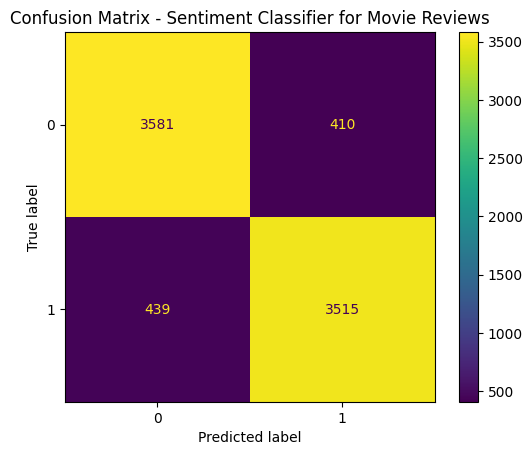

In [ ]:
Confm = confusion_matrix(Ytest,int_predictions)
display = ConfusionMatrixDisplay(Confm)
display.plot()
plt.title("Confusion Matrix - Sentiment Classifier for Movie Reviews")
plt.show()